In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Import essential packages

import cv2    
import math   
import matplotlib.pyplot as plt    
import pandas as pd
from keras.preprocessing import image   
import numpy as np    
from keras.utils import np_utils
from skimage.transform import resize   

### Read the video, extract frames from it and save them as images

In [3]:
VideoCap = cv2.VideoCapture("/kaggle/input/Videos/Tom and jerry.mp4")
count = 0
n = 0
fps = VideoCap.get(cv2.CAP_PROP_FPS)
while True:
    success, image = VideoCap.read()
    if success == False:
        break
    if (1*n)%math.floor(fps)==0:           #if  0.5*n we get 1 img for 2 sec, if 2*n we get 2 img for 1 sec
        filename ="/kaggle/input/images/Training_Images/frame"+str(count)+".jpg"
        cv2.imwrite(filename, image)
    
    n += 1
VideoCap.release()
print('Done')

Done


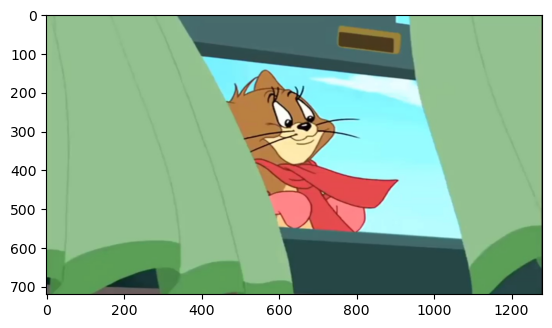

In [4]:
img = plt.imread("/kaggle/input/images/Training_Images/frame0.jpg")   # reading image using its name
plt.imshow(img)


### Label a few images for training the model

In [5]:
data = pd.read_csv("/kaggle/input/csv-files/mapping.csv")     # reading the csv file
data.head()      # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


In [6]:
data['Class'] = data['Class'].astype('str') 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  298 non-null    object
 1   Class     298 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
data_gen = ImageDataGenerator(rotation_range=0.2, zoom_range=0.2, horizontal_flip=True, rescale=1/255)

In [10]:
train_data = data_gen.flow_from_dataframe(data, directory="/kaggle/input/images/Training_Images/",
                             x_col='Image_ID',y_col='Class',target_size=(224,224))

Found 298 validated image filenames belonging to 3 classes.


In [11]:
train_data

### Building the model

In [12]:
from keras.models import Sequential,Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG16, InceptionV3,ResNet50
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,Dense,InputLayer,Dropout

In [13]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # include_top=False to remove the top layer

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
last_layer = Dense(3,activation='softmax')(Flatten()(base_model.output))

In [16]:
model = Model(inputs = base_model.input, outputs = last_layer)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer = 'adam')

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
hist = model.fit(train_data, epochs=50)

Epoch 1/50
10/10 [==============================] - 20s 683ms/step - loss: 5.5463 - accuracy: 0.4933
Epoch 2/50
10/10 [==============================] - 6s 576ms/step - loss: 2.6552 - accuracy: 0.7483
Epoch 3/50
10/10 [==============================] - 5s 531ms/step - loss: 1.2149 - accuracy: 0.8624
Epoch 4/50
10/10 [==============================] - 6s 549ms/step - loss: 0.7615 - accuracy: 0.8993
Epoch 5/50
10/10 [==============================] - 5s 536ms/step - loss: 0.4241 - accuracy: 0.9329
Epoch 6/50
10/10 [==============================] - 6s 585ms/step - loss: 0.2552 - accuracy: 0.9497
Epoch 7/50
10/10 [==============================] - 6s 542ms/step - loss: 0.1846 - accuracy: 0.9597
Epoch 8/50
10/10 [==============================] - 5s 525ms/step - loss: 0.1373 - accuracy: 0.9765
Epoch 9/50
10/10 [==============================] - 6s 553ms/step - loss: 0.0392 - accuracy: 0.9866
Epoch 10/50
10/10 [==============================] - 6s 548ms/step - loss: 0.1993 - accuracy: 0.969

In [ ]:
model.save('video_model.h5')

### Calculating the screen time for testing

In [19]:
VideoCap = cv2.VideoCapture("/kaggle/input/videos/Tom and Jerry 3.mp4")
count = 0
n = 0
fps = VideoCap.get(cv2.CAP_PROP_FPS)
while True:
    success, image = VideoCap.read()
    if success == False:
        break
    if (1*n)%math.floor(fps)==0:           #if  0.5*n we get 1 img for 2 sec, if 2*n we get 2 img for 1 sec
        filename ="Testing_Images/test"+str(count)+".jpg"
        cv2.imwrite(filename, image)
        count += 1
    n += 1
VideoCap.release()
print('Done')

Done


In [20]:
test = pd.read_csv("/kaggle/input/csv-files/test.csv")

### Predictions

In [21]:
def count_screen_time(path):
    A = cv2.imread(path)
    B = cv2.resize(A,(224,224))
    C = B/255
    yp = model.predict_on_batch(C.reshape(1,224,224,3)).argmax()
    return yp

In [22]:
import os 
filenames = os.listdir("/kaggle/input/images/Testing_Images/")

In [23]:
predictions = []

for filename in filenames:
    yp = count_screen_time("/kaggle/input/images/Testing_Images/"+filename)
    predictions.append(yp)

In [24]:
predictions = np.array(predictions)
predictions

array([2, 2, 0, 0, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 2,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2,
       0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2,
       2, 2, 1, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 1, 1, 2, 2, 2, 0, 2, 0])

In [25]:
print("The screen time of other is", predictions[predictions==0].shape[0], "seconds")
print("The screen time of JERRY is", predictions[predictions==1].shape[0]  , "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0] , "seconds")

The screen time of other is 64 seconds
The screen time of JERRY is 29 seconds
The screen time of TOM is 93 seconds
